In [1]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
from stuff import *

In [2]:
class ModifiedAttention(nn.Module):
    def __init__(self, original_attn):
        super(ModifiedAttention, self).__init__()
        self.qkv = original_attn.qkv
        self.attn_drop = original_attn.attn_drop
        self.proj = original_attn.proj
        self.proj_drop = original_attn.proj_drop
        self.num_heads = original_attn.num_heads
        self.scale = original_attn.scale

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn_weights = attn.clone()
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_weights

class ModifiedNestedTensorBlock(nn.Module):
    def __init__(self, original_block):
        super(ModifiedNestedTensorBlock, self).__init__()
        self.norm1 = original_block.norm1
        self.attn = ModifiedAttention(original_block.attn)
        self.ls1 = original_block.ls1
        self.drop_path1 = original_block.drop_path1
        self.norm2 = original_block.norm2
        self.mlp = original_block.mlp
        self.ls2 = original_block.ls2
        self.drop_path2 = original_block.drop_path2

    def forward(self, x, return_attention=False):
        if return_attention:
            x_norm = self.norm1(x)
            attn_output, attn_weights = self.attn(x_norm)
            x = x + self.drop_path1(self.ls1(attn_output))
            x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
            return x, attn_weights
        else:
            x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))[0]))
            x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
            return x
        
class SingleHeadAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SingleHeadAttention, self).__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.scale = (embed_dim // 1) ** -0.5  # Single head
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, 1, C // 1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn_weights = attn.clone()
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn_weights

class croDINO(nn.Module):
    def __init__(self, repo_name="facebookresearch/dinov2", model_name="dinov2_vitb14", pretrained=True):
        super(croDINO, self).__init__()
        original_model = torch.hub.load(repo_name, model_name)
        modified_blocks = nn.ModuleList([ModifiedNestedTensorBlock(blk) for blk in original_model.blocks])
        
        self.patch_embed = original_model.patch_embed
        self.blocks = modified_blocks
        self.norm = original_model.norm
        self.head = original_model.head
        
        # Positional Encoding
        num_patches = original_model.patch_embed.proj.weight.shape[0]
        embed_dim = original_model.patch_embed.proj.out_channels
        self.pos_embed = nn.Parameter(torch.cat([original_model.pos_embed[:, :num_patches], original_model.pos_embed[:, :num_patches]], dim=1))
        
        # Ensure the positional embedding matches the concatenated tokens
        self.pos_embed = nn.Parameter(self.pos_embed[:, :512, :])  # 512 = 256 patches per image * 2 images

        # Final single-head attention layer
        self.final_attention = SingleHeadAttention(embed_dim)
        
        # Freeze parameters if pretrained is True
        if pretrained:
            for param in self.patch_embed.parameters():
                param.requires_grad = False
            for param in self.blocks.parameters():
                param.requires_grad = False
            for param in self.norm.parameters():
                param.requires_grad = False
            for param in self.head.parameters():
                param.requires_grad = False

    def forward(self, x1, x2, return_attention=False):
        x1 = self.patch_embed(x1)
        x2 = self.patch_embed(x2)
        
        # Concatenate tokens from both images
        x = torch.cat((x1, x2), dim=1)
        
        # Add positional encoding
        x = x + self.pos_embed
        
        # Collect attention weights if needed
        attention_weights = []
        
        # Process through transformer blocks
        for blk in self.blocks:
            if return_attention:
                x, attn = blk(x, return_attention=True)
                attention_weights.append(attn)
            else:
                x = blk(x)
        
        # Final single-head attention
        _, final_attn = self.final_attention(x)         # NOTE: I'm computing the attention without affecting the patches
        if return_attention:
            attention_weights.append(final_attn)
        
        x = self.norm(x)
        x = self.head(x)
        
        if return_attention:
            return x, attention_weights
        else:
            return x


# Sample paired images
dataset_path = '/home/lrusso/cvusa'
train_filenames, val_filenames = sample_paired_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='cutouts')

# Settings
image_size = 224
aerial_scaling = 3
provide_paths = False

transform_ground = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

transform_aerial = transforms.Compose([
    transforms.Resize((int(image_size * aerial_scaling), int(image_size * aerial_scaling))),
    transforms.CenterCrop((image_size//2, image_size//2)),
    transforms.ToTensor()
])

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground)
data_loader = DataLoader(paired_dataset, batch_size=1, shuffle=True)

# Define the new model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = croDINO(pretrained=True).to(device)

# Load a single pair of images
ground_image, aerial_image = next(iter(data_loader))
ground_image = ground_image.to(device)
aerial_image = aerial_image.to(device)

# Compute the output of the model
output, attentions = model(ground_image, aerial_image, return_attention=True)


Using device: cuda


Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main
/home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/home/lrusso/miniconda3/envs/crossview/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


RuntimeError: The size of tensor a (320) must match the size of tensor b (512) at non-singleton dimension 1

attention shape:  torch.Size([512, 512])
attention dtype:  torch.float32


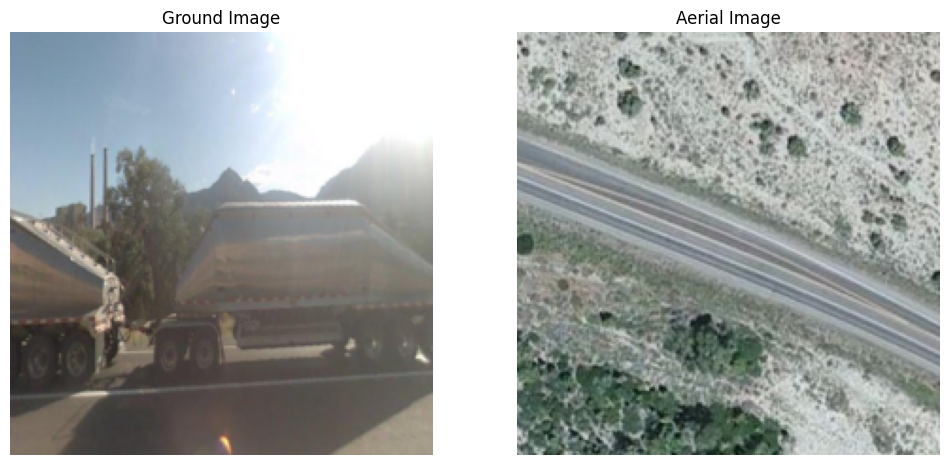

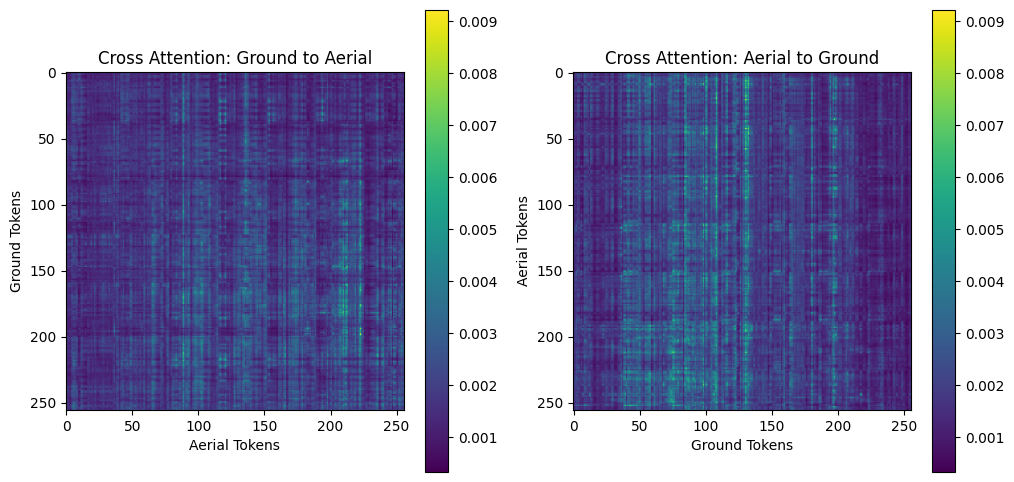

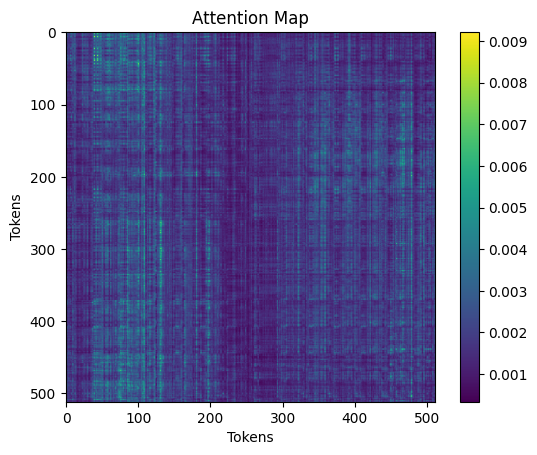

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the final single-head attention layer
attention = attentions[-1].mean(dim=(0, 1))  # average across batch and heads
print("attention shape: ", attention.shape)
print("attention dtype: ", attention.dtype)

# Extract the cross-attention submatrices
cross_attention_G2A = attention[:256, 256:].detach().cpu().numpy()
cross_attention_A2G = attention[256:, :256].detach().cpu().numpy()

# Convert images to numpy for visualization
ground_image_np = ground_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
aerial_image_np = aerial_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# Plot the ground image and aerial image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ground_image_np)
ax[0].set_title("Ground Image")
ax[0].axis('off')
ax[1].imshow(aerial_image_np)
ax[1].set_title("Aerial Image")
ax[1].axis('off')
plt.show()

# Determine common vmin and vmax for color scales
vmin = min(cross_attention_G2A.min(), cross_attention_A2G.min())
vmax = max(cross_attention_G2A.max(), cross_attention_A2G.max())

# Plot the cross-attention maps with common color scale
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cross Attention: Ground to Aerial
img0 = ax[0].imshow(cross_attention_G2A, cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title("Cross Attention: Ground to Aerial")
ax[0].set_xlabel("Aerial Tokens")
ax[0].set_ylabel("Ground Tokens")
fig.colorbar(img0, ax=ax[0])

# Cross Attention: Aerial to Ground
img1 = ax[1].imshow(cross_attention_A2G, cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title("Cross Attention: Aerial to Ground")
ax[1].set_xlabel("Ground Tokens")
ax[1].set_ylabel("Aerial Tokens")
fig.colorbar(img1, ax=ax[1])

plt.show()

# Visualize the whole attention map with common color scale
plt.imshow(attention.squeeze().detach().cpu().numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Attention Map")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.colorbar()
plt.show()


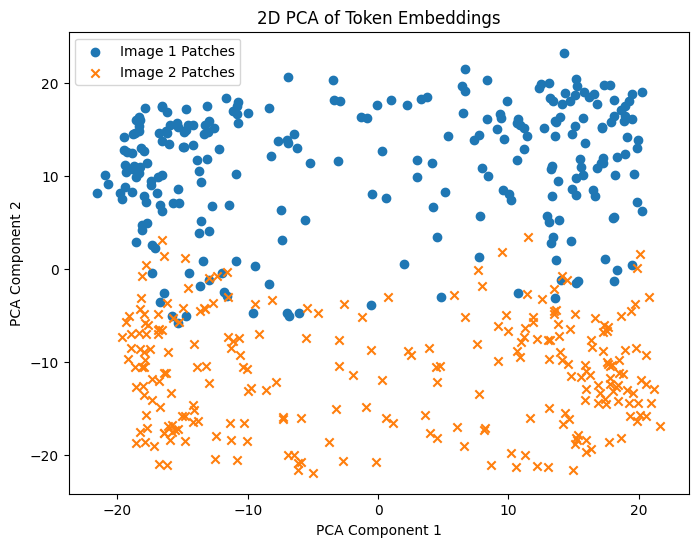

In [ ]:
# Flatten the output
output_np = output.squeeze(0).detach().cpu().numpy()  # Remove batch dimension and convert to NumPy

# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(output_np)

# Plot the 2D projections
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:256, 0], pca_result[:256, 1], label='Image 1 Patches')
plt.scatter(pca_result[256:, 0], pca_result[256:, 1], label='Image 2 Patches', marker='x')
plt.title("2D PCA of Token Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()